In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from pathlib import Path
import pgen.utils as utils
common_vars = utils.CommonVars()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.Align import substitution_matrices
import nwalign3 as nw  
import dill

In [12]:
import numpy as np

In [13]:
russ_train_location = Path(common_vars.project_dir) / "data" / "Russ_994_random.fasta"
tau_train_location = Path(common_vars.project_dir) / "data" / "tautomerase_2953.fasta"
output_dir = Path(common_vars.project_dir) / "outputs" / "graphs"

In [14]:
sub_matrices = {
    "BLOSUM62": substitution_matrices.load("BLOSUM62"),
    "BLOSUM90": substitution_matrices.load("BLOSUM90")
}

def align_sequences(sequenceA, sequenceB, print_alignment=False, matrix="BLOSUM62"):
    alignment = nw.global_align(sequenceA, sequenceB, matrix=matrix, gap_open=-0.5, gap_extend=-0.1)
    if print_alignment:
        print(alignment[0])
        print(alignment[1])
    score = nw.score_alignment(alignment[0],alignment[1], matrix=Path(nw.__file__).parent / "matrices" / matrix, gap_open=-0.5, gap_extend=-0.1)


    return score

# def align_sequences(sequenceA, sequenceB, print_alignment=False, matrix="BLOSUM62"):
#     if matrix is not None: 
#         match_dict = sub_matrices[matrix]
#         alignments = pairwise2.align.globaldx(sequenceA=sequenceA, sequenceB=sequenceB, match_dict=match_dict)
#     else:
#         alignments = pairwise2.align.globalxx(sequenceA=sequenceA, sequenceB=sequenceB)
  
#     if print_alignment:
#         print(format_alignment(*alignments[0]))

#     return (alignments[0].score)

In [15]:
russ_values = {
    "CM2_Trn": "data/Russ_994_random.fasta",
    "Russ": "outputs/models/russ/russ_gen.fasta",
    "CM2_Tst": "data/Russ_226_random.fasta",
    "Tau_Tst": "data/tautomerase_738.fasta",
    "1_S": "outputs/models/ESM34/esm34_CH_2_e_coli_full_sequential_k0.fasta",
    "1_R": "outputs/models/ESM34/E_coli_parallel_esm34.fasta",
    "1_B": "outputs/models/ESM34/E_coli_parallel_burnin_esm34.fasta",
    "1_C": "outputs/models/ESM34/E_coli_CM2_first_20_2549bd_trial1.fasta",
    "1_N": "outputs/models/ESM34/NoSeed_2549bd_trial2.fasta",
    "2_B": "outputs/models/esm1_t12_85M_UR50S/E_coli_parallel_burnin_esm12.fasta",
    "3_B": "outputs/models/esm1_t12_85M_UR50S/finetuned/Russ_994_random/Dec04_13-47-23_6fb55ea4/generated_sequences/E_coli_CM2_6b9c30_trial5.fasta",
    "3_C": "outputs/models/esm1_t12_85M_UR50S/finetuned/Russ_994_random/Dec04_13-47-23_6fb55ea4/generated_sequences/E_coli_CM2_first_20_7d2781_trial1.fasta",
    "3_N": "outputs/models/esm1_t12_85M_UR50S/finetuned/Russ_994_random/Dec04_13-47-23_6fb55ea4/generated_sequences/NoSeed_83abbe_trial2.fasta",
    "4_B": "outputs/models/esm1_t12_85M_UR50S/finetuned/tautomerase_2953/Dec04_14-13-14_c8588459/generated_sequences/E_coli_CM2_bb1f59_trial5.fasta",
    "5_B": "outputs/models/ProtBert-BFD/E_coli_CM2_db515f_trial1.fasta",
    "8_N": "outputs/models/ProtBert12-Russ/russ_from_scratch_100_epochs_no_seed.fasta",
    "6_N": "outputs/models/3_gram_CM_2/Russ_994_random_3gram_generation_seed_s_len92.fasta",
    "HMM": "outputs/models/hmmemit/Russ_994_hmmemit.fasta"
}

tau_values = {
    "Tau_Trn": "data/tautomerase_2953.fasta",
    "Tau_Tst": "data/tautomerase_738.fasta",
    "4_B": "outputs/models/esm1_t12_85M_UR50S/finetuned/tautomerase_2953/Dec04_14-13-14_c8588459/generated_sequences/E_coli_CM2_bb1f59_trial5.fasta",
    "4_N": "outputs/models/esm1_t12_85M_UR50S/finetuned/tautomerase_2953/Dec04_14-13-14_c8588459/generated_sequences/NoSeed_30995f_trial2.fasta",
    "7_N": "outputs/models/3_gram_Tautomerase/tautomerase_2953_3gram_generation_seed_s_len60.fasta"
}



In [16]:
def process_key(file_loc, train_sequence):
    try:
        samples = utils.parse_fasta(file_loc)
    except Exception as e:
        print(f"skipping file:{file_loc}")
        return [],[]
    results = []
    print(file_loc)
    for sample in samples:
        best = 0
        for ref_sequence in train_sequence:
            score = align_sequences(ref_sequence, sample)
            best = max(best, score)
        results.append(best)
    return samples, results

In [ ]:
russ_samples = {}
russ_results = {}
tau_samples = {}
tau_results = {}

russ_train = utils.parse_fasta(russ_train_location)
tau_train = utils.parse_fasta(tau_train_location)

for sample_name, data_path in russ_values.items():
    sample, result = process_key(Path(common_vars.project_dir) / data_path, russ_train)
    russ_samples[sample_name] = sample
    russ_results[sample_name] = result

# for sample_name, data_path in tau_values.items():
#     sample, result = process_key(Path(common_vars.project_dir) / data_path, tau_train)
#     tau_samples[sample_name] = sample
#     tau_results[sample_name] = result

In [21]:
with open(output_dir / "alignment_backup_nwalgin_2", 'wb') as backup_file:
    dill.dump((russ_samples, russ_results, tau_samples, tau_results), backup_file)
with open(output_dir / "alignment_backup_nwalgin_2", 'rb') as backup_file:
    data = dill.load(backup_file)


In [24]:
(russ_samples, russ_results, tau_samples, tau_results) = data

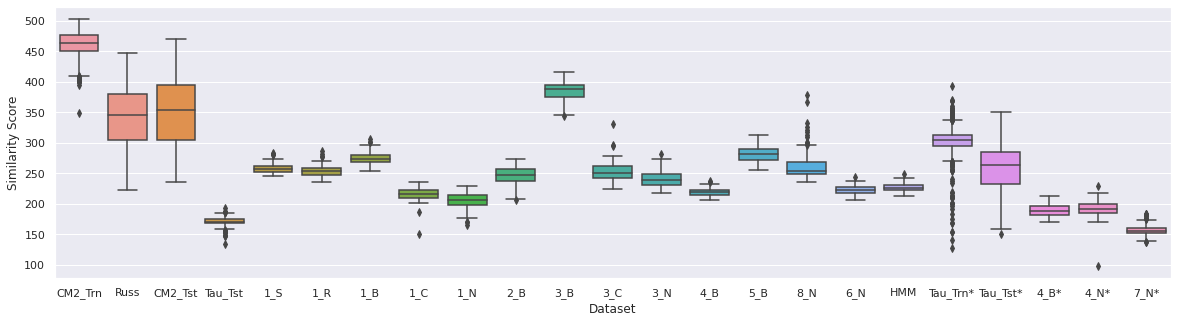

In [25]:
plt.clf()
df = pd.DataFrame()
scores = list()
datasets = list()
for k,v in russ_results.items():
    scores += v
    datasets += [k] * len(v)
for k,v in tau_results.items():
    scores += v
    datasets += [k + "*"] * len(v)
df["Dataset"] = datasets
df["Similarity Score"] = scores

sns.set(rc={'figure.figsize':(20,4)})
ax = sns.boxplot(x="Dataset", y="Similarity Score", data=df)
ax.figure.set_size_inches(20,5)
ax.figure.savefig(output_dir / "identity_wrt_most_aligned_training_value_both_nwalign_2.png")